In [1]:
import phylovelo as pv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import scanpy as sc
import re
import warnings
from copy import deepcopy
from io import StringIO
from itertools import combinations
from Bio import Phylo
from scipy.stats import chi2, nbinom, pearsonr,spearmanr
from sklearn.neighbors import NearestNeighbors

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
plt.rcParams['font.size'] = 12

In [12]:
data = sc.read_loom('/data3/wangkun/phylovelo_datasets/larry_normed.loom')

In [14]:
color_map = dict(zip(set(data.obs['Cell type annotation']), range(11)))
color_map_inv = dict(zip(range(11), set(data.obs['Cell type annotation'])))

In [15]:
from collections import Counter
clone_size = Counter(data.obs['Clone'])
clone_size.pop('None')

81585

In [16]:
selected_clones = np.array(list(clone_size.keys()))[(np.array(list(clone_size.values()))>10)&(np.array(list(clone_size.values()))<100)]
selected_cells = data.obs['Cell barcode'][np.isin(data.obs['Clone'], selected_clones)]
selected_data = data[selected_cells.index,]

In [8]:
sd = pv.scData(count=pd.DataFrame(data=selected_data.X.A, index=selected_data.obs_names, columns=selected_data.var_names),
                           Xdr=pd.DataFrame(data=selected_data.obs[['SPRING-x','SPRING-y']]),
                          )

In [9]:
sd.drop_duplicate_genes()
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)
sd.x_normed = sd.count

In [27]:
import re
drop_genes = []
for i in sd.x_normed.columns:
    for num in re.finditer('[0-9]+', i):
        if len(num.group(0)) > 4:
            drop_genes.append(i)
            continue
sd.x_normed = sd.x_normed[sd.x_normed.columns[~np.isin(sd.x_normed.columns, drop_genes)]]

In [222]:
clone_size = Counter(selected_data.obs['Clone'])
depths = [clone_size[i] for i in selected_data.obs['Clone']]

In [35]:
pv.velocity_inference(sd, np.round(np.log(depths), 1), cutoff=0.97)
pv.velocity_embedding(sd, target='x_normed', n_neigh=300)

  0%|          | 0/13979 [00:00<?, ?it/s]

  0%|          | 0/29242 [00:00<?, ?it/s]

In [37]:
sd.velocity_embeded[np.isnan(sd.velocity_embeded)] = [0,0,0,0]

In [38]:
color_map = {'Erythroid': '#b6c5e4',
 'Meg': '#9d48f1',
 'Ccr7_DC': '#e7893e',
 'Undifferentiated': '#4875ae',
 'Mast': '#80594f',
 'Baso': '#68bccb',
 'Monocyte': '#579b6e',
 'pDC': '#b5bd71',
 'Lymphoid': '#eeafaf',
 'Neutrophil': '#bd4038',
 'Eos': '#f4aeae'}
color_map_inv = {}
for key in color_map:
    color_map_inv[color_map[key]] = key

In [88]:
state_map = {0: 'Monocyte',
 1: 'Undifferentiated',
 2: 'Ccr7_DC',
 3: 'Baso',
 4: 'Erythroid',
 5: 'pDC',
 6: 'Lymphoid',
 7: 'Eos',
 8: 'Mast',
 9: 'Meg',
 10: 'Neutrophil'}

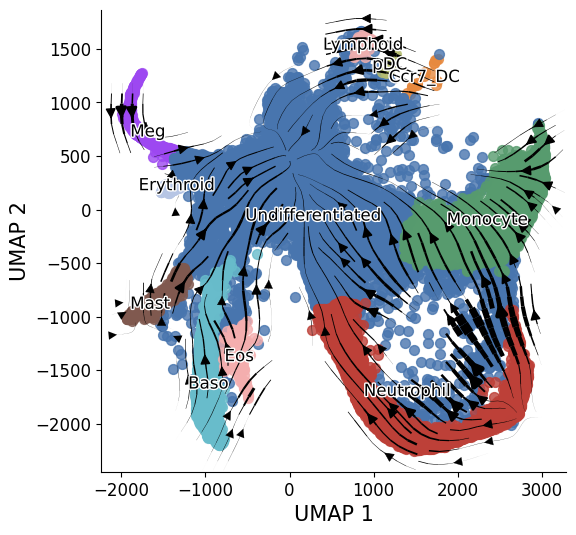

In [39]:
c = np.array(list((map(lambda x: color_map[x], selected_data.obs['Cell type annotation']))))
fig, ax = plt.subplots(figsize=(6, 6))
for i in color_map_inv.keys():
    ax.scatter(selected_data.obs['SPRING-x'][c==i], selected_data.obs['SPRING-y'][c==i], color=i, label=color_map_inv[i], alpha=0.8, s=50)
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream', radius=100, lw_coef=40, arrowsize=1.5)
pv.label_name(sd.Xdr.to_numpy(), selected_data.obs['Cell type annotation'], ax)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# ax.legend(bbox_to_anchor=(1,1), fontsize=10, loc='upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('../figures/fig6/larry.pdf', format='pdf')

In [15]:
cmap = ListedColormap(['#00429d', '#558dbf', '#49e5e6'])

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(selected_data.obs['SPRING-x'][selected_data.obs['Time point']==6], selected_data.obs['SPRING-y'][selected_data.obs['Time point']==6], c='#49e5e6', alpha=0.3, label='Day 6')
ax.scatter(selected_data.obs['SPRING-x'][selected_data.obs['Time point']==4], selected_data.obs['SPRING-y'][selected_data.obs['Time point']==4], c='#558dbf', alpha=0.3, label='Day 4')
ax.scatter(selected_data.obs['SPRING-x'][selected_data.obs['Time point']==2], selected_data.obs['SPRING-y'][selected_data.obs['Time point']==2], c='#00429d', alpha=0.3, label='Day 2')
# ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream', radius=100, lw_coef=40, arrowsize=1.5)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
lgnd = ax.legend(bbox_to_anchor=(1,1), fontsize=10, loc='upper left')
for i in lgnd.legendHandles:
    i._sizes = [60]
    i._alpha = [1]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('../figures/larry_time.pdf')

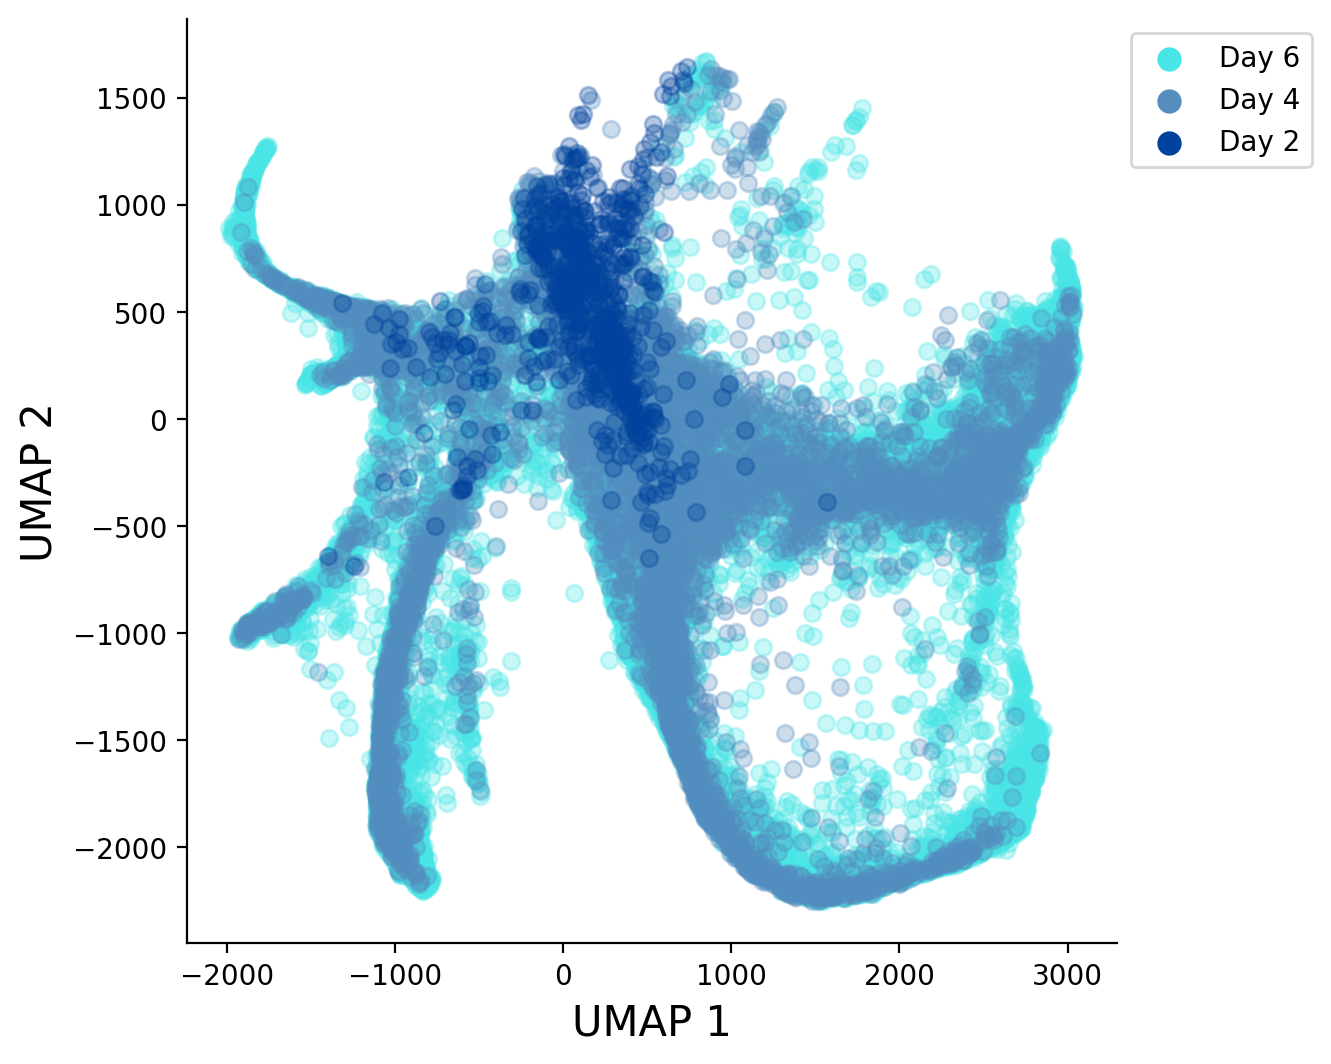

In [52]:
plt.show()

In [44]:
v_megs = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns, columns=['velocity']).loc[sd.megs]
v_megs['p_value']=sd.pvals.T
v_megs['q_value']=sd.qvals.T
v_megs.to_csv('../megs/Larry.csv')

In [75]:
pv.calc_phylo_pseudotime(sd, r_sample=0.02, n_neighbors=200)

  0%|          | 0/583 [00:00<?, ?it/s]

In [303]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots()

scatter=ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=sd.phylo_pseudotime, s=10, cmap='plasma')
ax.figure.set_size_inches(6, 6)

# ax.set_xlabel('UMAP 1', fontsize=15)
# ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
# ax.set_xlim(-2.5, 14)

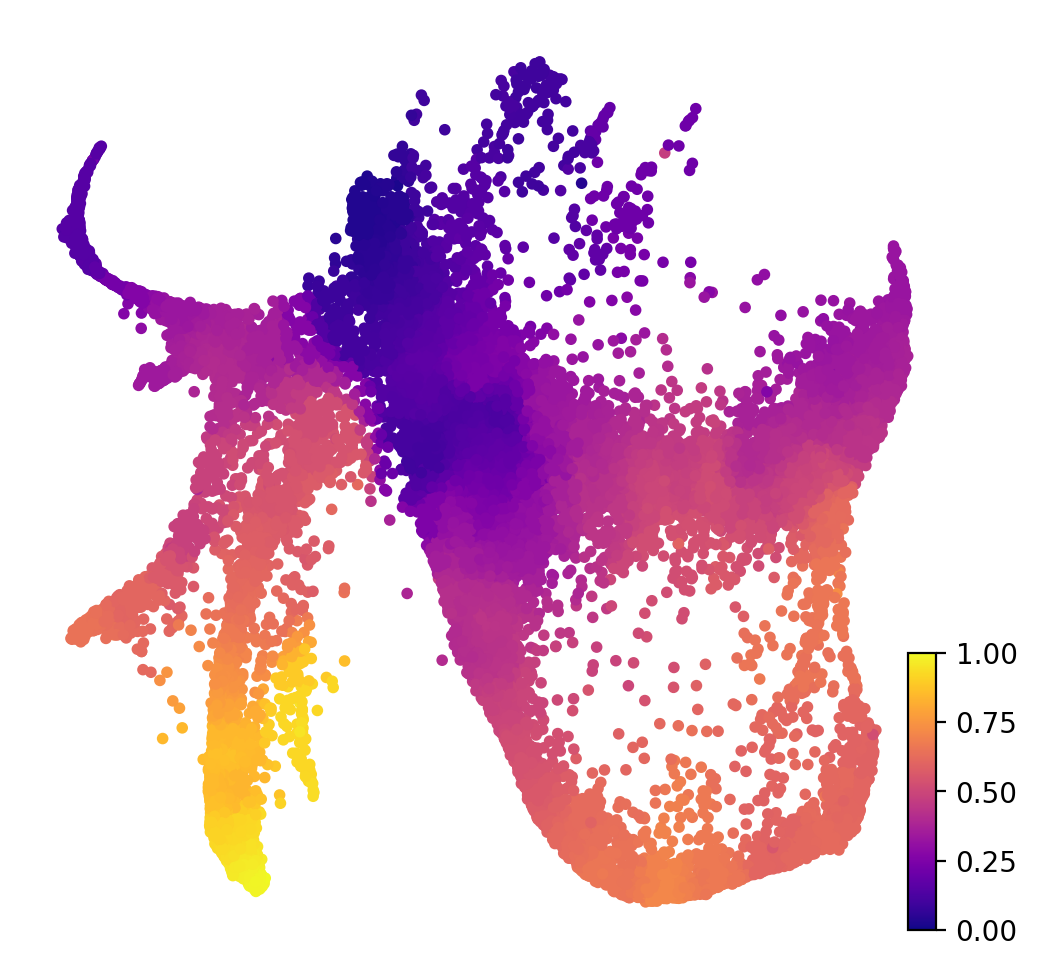

In [304]:
plt.show()

In [99]:
import cospar as cs

In [9]:
import dynamo as dyn
import anndata as ad

In [10]:
adata = ad.AnnData(sd.x_normed)

In [21]:
adata.obs['cell_states'] = selected_data.obs['Cell type annotation']

In [26]:
adata.obsm['X_umap'] = sd.Xdr.to_numpy()

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


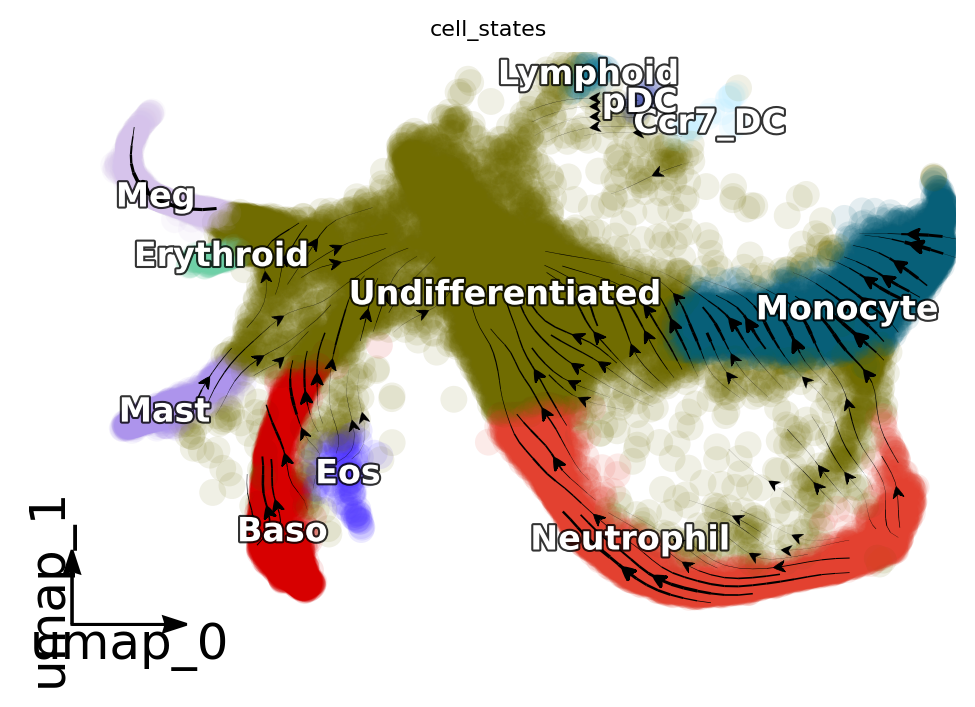

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [42.7928s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----------> not all cells are used, set diag to 1...
|-----------> Constructing W matrix according upsampling=True and downsampling=True options...
|-----> [ddhodge completed] in progress: 100.0

Calculating 2-D curl: 100%|██████████| 29242/29242 [00:01<00:00, 19525.17it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 30/30 [00:01<00:00, 21.64it/s]

|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.


|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [105.2363s]


/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----------> not all cells are used, set diag to 1...
|-----------> Constructing W matrix according upsampling=True and downsampling=True options...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [58.2551s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7fb32481f700>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7fb32451c580>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edge

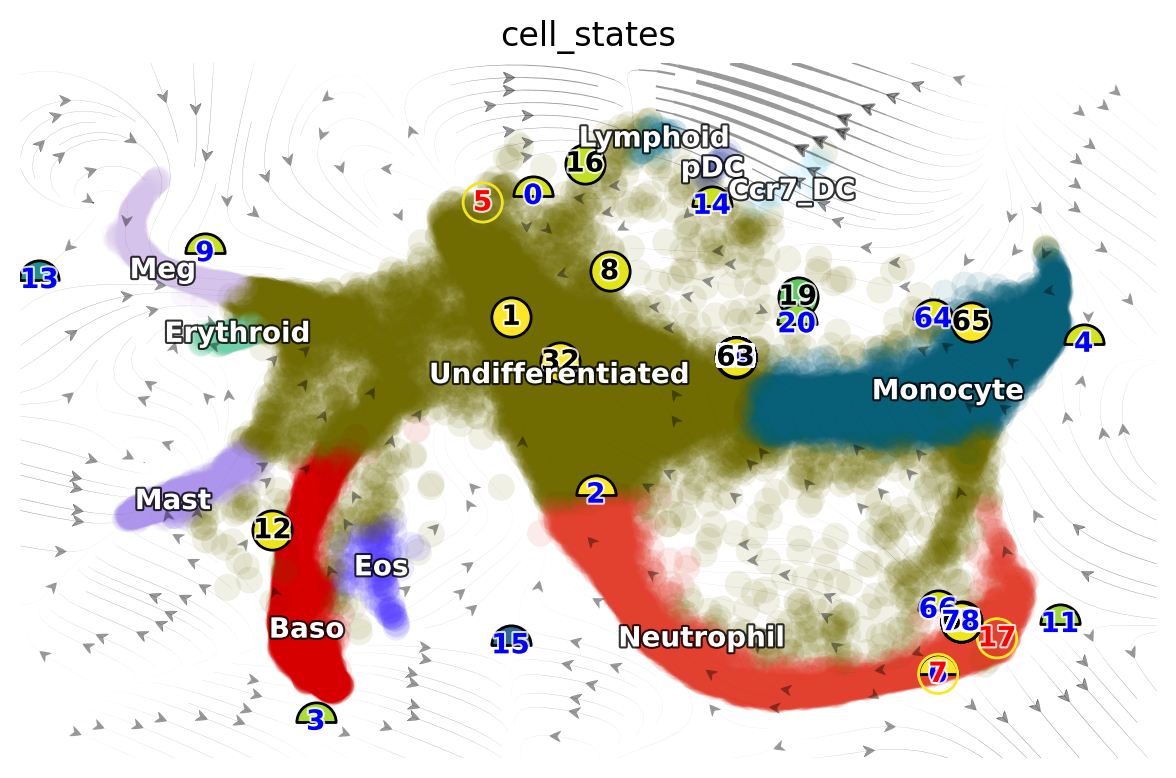

In [27]:
adata.obsm['velocity_umap'] = sd.velocity_embeded
dyn.pl.streamline_plot(adata, color=['cell_states'], basis='umap', show_legend='on data', show_arrowed_spines=True)
dyn.vf.VectorField(adata, basis='umap', M=1000, pot_curl_div=True)
dyn.vf.topography(adata, basis='umap')
dyn.ext.ddhodge(adata, basis='umap')
dyn.pl.topography(adata,color='cell_states')

In [29]:
dyn.pd.state_graph(adata, group='cell_states', basis='umap', method='vf')

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0067s]
|-----> [iterate groups] in progress: 9.0909%

uniformly sampling points along a trajectory:  35%|███▌      | 35/100 [00:00<00:00, 342.50it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 298.52it/s]


|-----> [iterate groups] in progress: 18.1818%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 314.74it/s]


|-----> [iterate groups] in progress: 27.2727%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 334.04it/s]


|-----> [iterate groups] in progress: 36.3636%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 322.15it/s]


|-----> [iterate groups] in progress: 45.4545%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:  32%|███▏      | 32/100 [00:00<00:00, 313.24it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 300.26it/s]


|-----> [iterate groups] in progress: 54.5455%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 345.04it/s]


|-----> [iterate groups] in progress: 63.6364%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 307.17it/s]


|-----> [iterate groups] in progress: 72.7273%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████| 35/35 [00:00<00:00, 330.18it/s]

|-----> [iterate groups] in progress: 81.8182%


/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 338.60it/s]


|-----> [iterate groups] in progress: 90.9091%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████| 18/18 [00:00<00:00, 319.56it/s]


|-----> [iterate groups] in progress: 100.0000%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████| 18/18 [00:00<00:00, 329.21it/s]


|-----> [iterate groups] in progress: 100.0000%
|-----> [iterate groups] finished [8.8068s]
|-----> [State graph estimation] in progress: 100.0000%
|-----> [State graph estimation] finished [0.0019s]


/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]


AnnData object with n_obs × n_vars = 29242 × 13979
    obs: 'cell_states', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap'
    uns: 'cell_states_colors', 'VecFld_umap', 'cell_states_graph'
    obsm: 'velocity_umap', 'X_umap', 'velocity_umap_SparseVFC', 'X_umap_SparseVFC'

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


<Figure size 640x480 with 0 Axes>

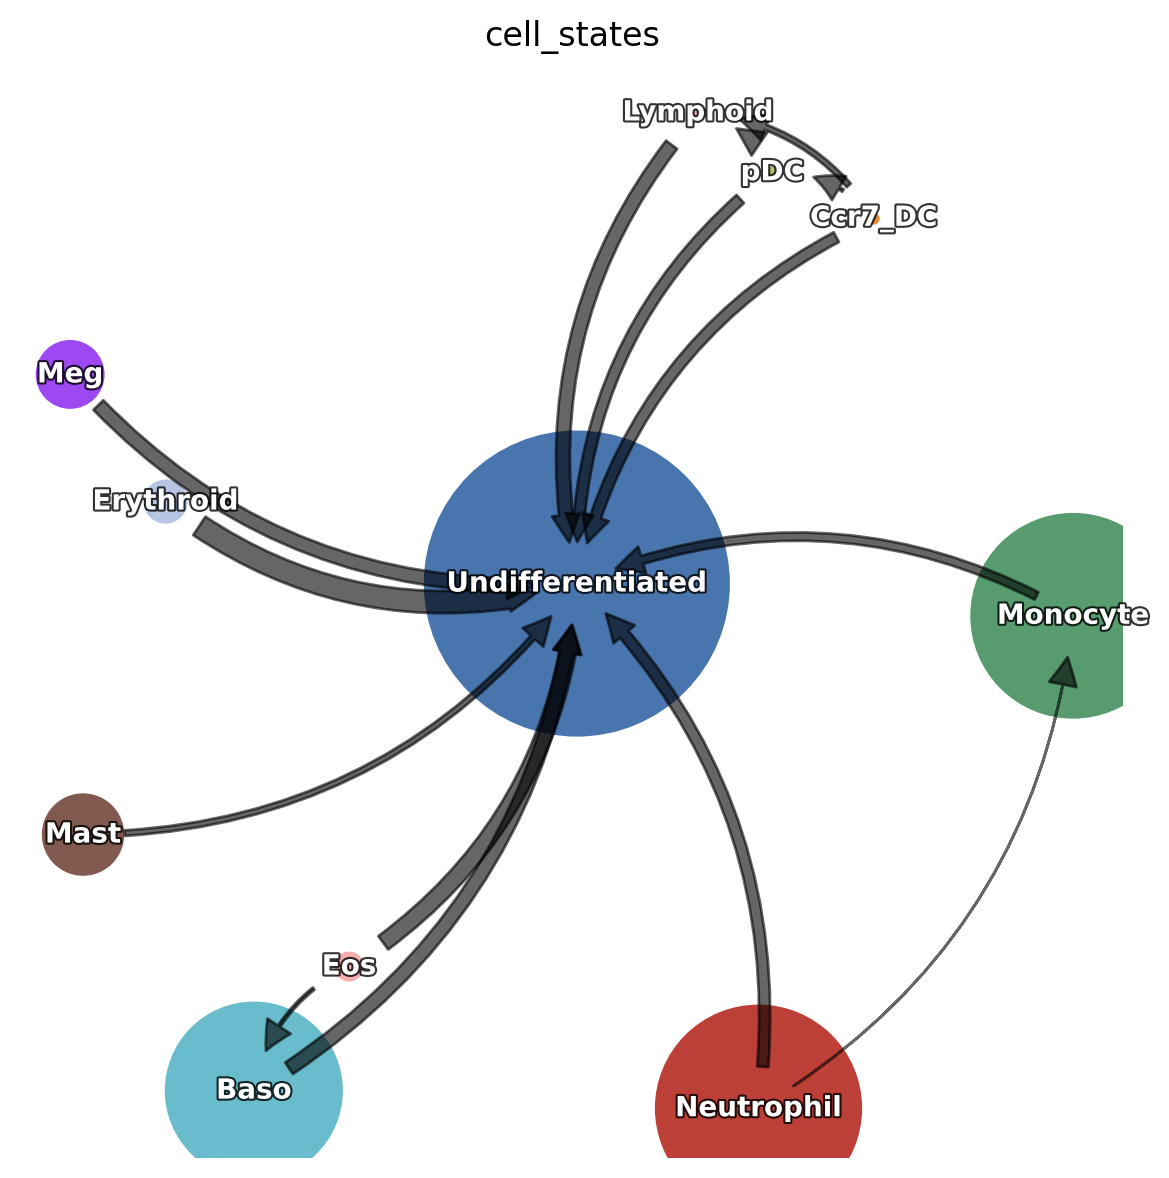

In [39]:
ax = dyn.pl.state_graph(adata,
                        color=['cell_states'],
                        group='cell_states',
                        basis='umap',
                        show_legend='on data',
                        method='vf',
                        figsize=(6,6),
                        color_key=color_map,
                        save_show_or_return='show',  
                        stack_colors_title =None,
                        graph_alpha=0.6*np.ones((11,11))
                  )
# ax=ax[0]
# ax.set_ylim(-6.3, 10)
# ax.set_xlim(-10, 5)

In [63]:
ax = dyn.pl.state_graph(adata,
                        color=['cell_states'],
                        group='cell_states',
                        basis='umap',
                        show_legend='on data',
                        method='vf',
                        figsize=(4,4),
                        color_key=color_map,
                        save_show_or_return='save',  
                        stack_colors_title =None,
                        graph_alpha=0.6*np.ones((11,11)),
                        path = '../figure/larry_transit.pdf'
                       )
# plt.savefig('../figures/larry_transit.pdf')
plt.show()

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type
Saving figure to /home/wangkun/phylovelo_new/PhyloVelo/notebooks/test/state_graph_dyn_savefig.pdf...
Done


<Figure size 640x480 with 0 Axes>

In [2]:
fate_potency = pd.read_csv('/data3/wangkun/larry_fate_potency.csv', index_col=0)

In [3]:
fate_potency = fate_potency[~fate_potency['fp'].isna()]

In [129]:
pvpt = pd.DataFrame(sd.Xdr)
pvpt['pt'] = sd.phylo_pseudotime

In [148]:
from tqdm import tqdm

In [172]:
pt_match = []
fp_match = []
pt_match_ind, fp_match_ind = [], []
for i in tqdm(pvpt.index):
    fp_tmp = fate_potency[(fate_potency['0']==pvpt.loc[i][0]) & (fate_potency['1']==pvpt.loc[i][1])]
    if fp_tmp.shape[0] > 0:
        pt_match.append(pvpt.loc[i][2])
        fp_match.append(float(fp_tmp['fp']))
        pt_match_ind.append(i)
        fp_match_ind.append(fp_tmp.index[0])

100%|██████████| 29242/29242 [00:12<00:00, 2351.89it/s]


In [159]:
pt_match, fp_match = np.array(pt_match), np.array(fp_match)

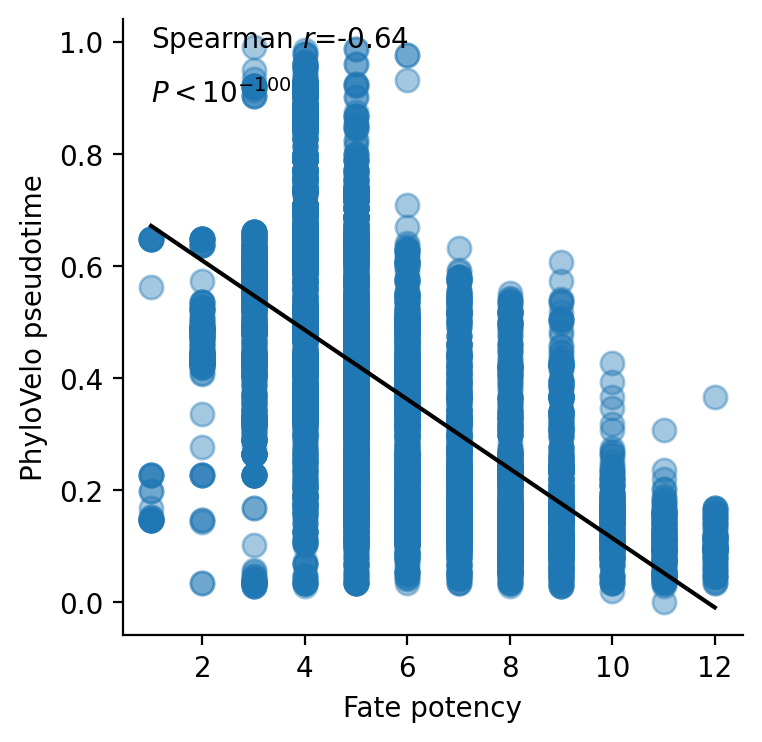

In [158]:
fig, ax = plt.subplots(figsize=(4,4))
pv.corr_plot(fp_match, pt_match, ax, stats='spearman')
ax.set_xlabel('Fate potency')
ax.set_ylabel('PhyloVelo pseudotime')
plt.show()

In [169]:
pt_vio = []
for i in range(2, 12):
    pt_vio.append(pt_match[fp_match==i])

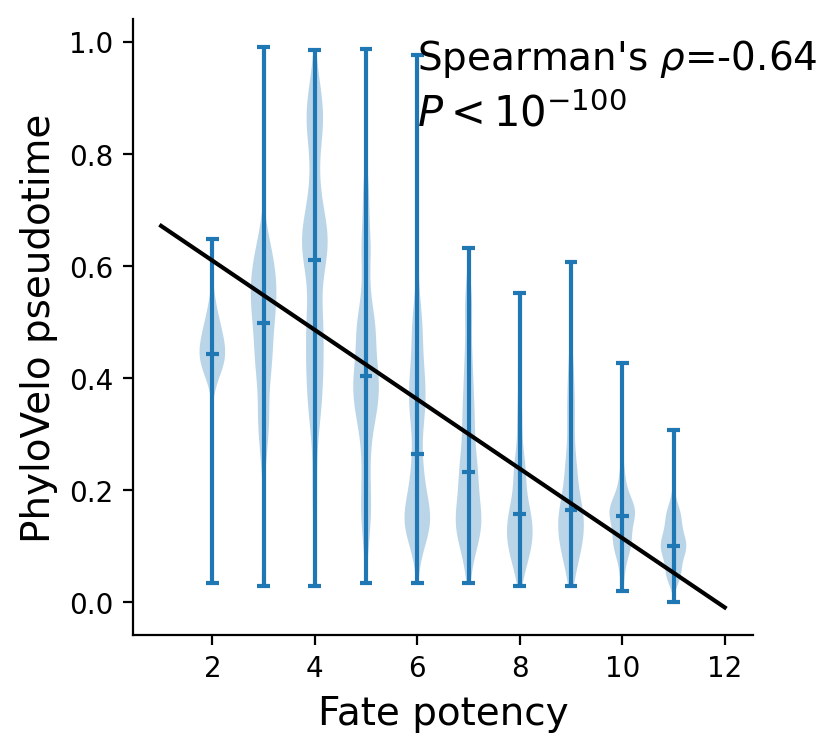

In [179]:
x = fp_match
y = pt_match

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(1, 12 ,60) + b

fig, ax = plt.subplots(figsize=(4, 4))
ax.violinplot(pt_vio, positions=range(2, 12), showmedians=1)
ax.plot(np.linspace(1, 12 ,60), y_est, '-', c='k')
ax.set_xlabel('Fate potency', fontsize=14)
ax.set_ylabel('PhyloVelo pseudotime', fontsize=14)
rho, pval = spearmanr(x, y)
ax.text(6, 0.95, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=14)
ax.text(6, 0.85, u"$P<10^{-100}$", fontsize=15)
# ax.text(6.5, 0.88, r'$p={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

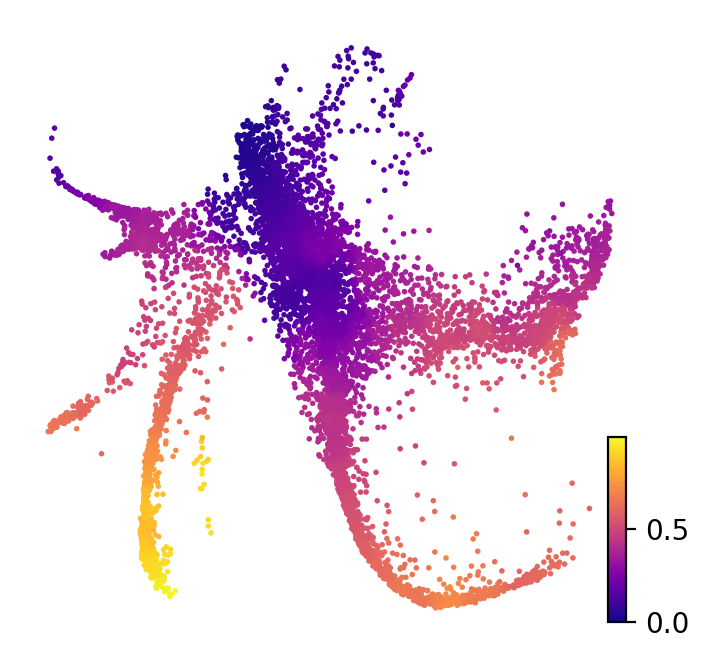

In [193]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(4,4))
scat = ax.scatter(pvpt.loc[pt_match_ind].iloc[:,0], pvpt.loc[pt_match_ind].iloc[:,1], c=pvpt.loc[pt_match_ind].iloc[:,2], s=1, cmap='plasma')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scat, cax=cbaxes, orientation='vertical')
plt.show()

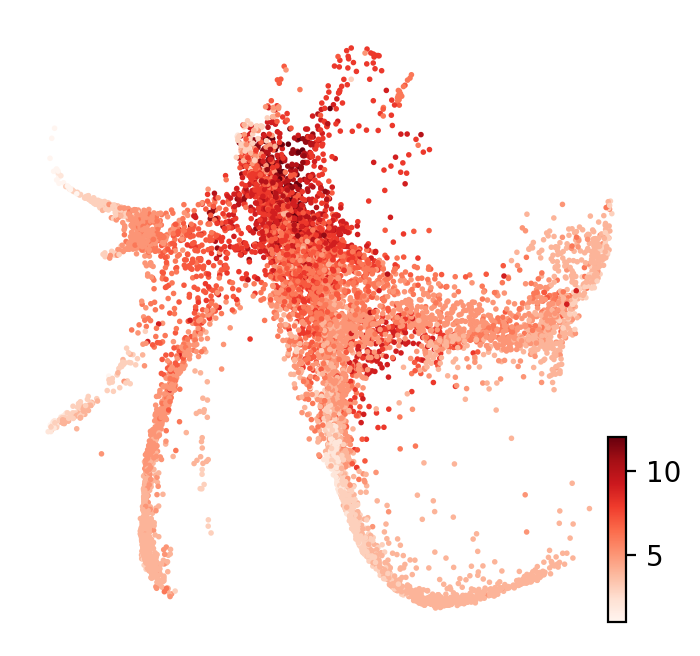

In [194]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(4,4))
scat = ax.scatter(fate_potency.loc[fp_match_ind].iloc[:,0], fate_potency.loc[fp_match_ind].iloc[:,1], c=fate_potency.loc[fp_match_ind].iloc[:,2], s=1, cmap='Reds')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scat, cax=cbaxes, orientation='vertical')
plt.show()

In [ ]:
v_megs = pd.read_csv('../megs/Larry.csv', index_col=0)

In [209]:
rpgs = []
for i in v_megs.index:
    if i[:2] == 'Rp':
        rpgs.append(i)

In [212]:
sc.tl.score_genes(adata, rpgs)

/home/wangkun/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


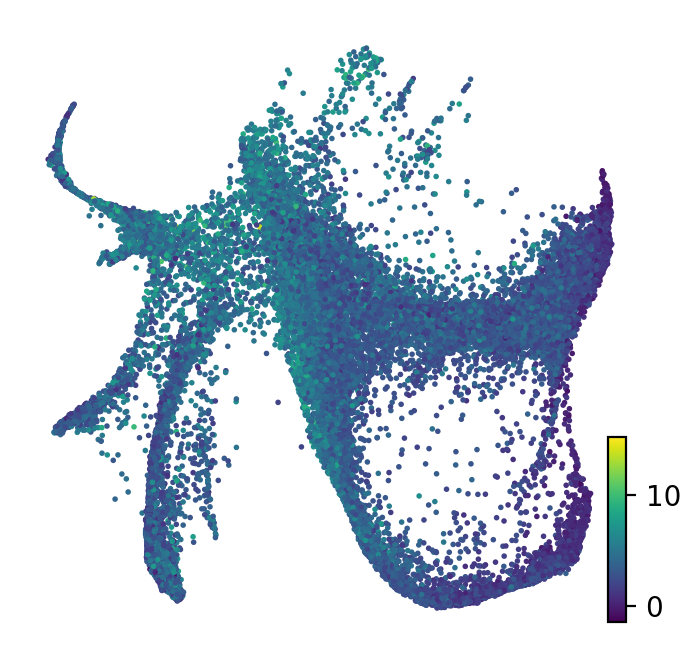

In [217]:

fig, ax = plt.subplots(figsize=(4,4))
scat = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], c=adata.obs['score'], s=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scat, cax=cbaxes, orientation='vertical')
plt.show()

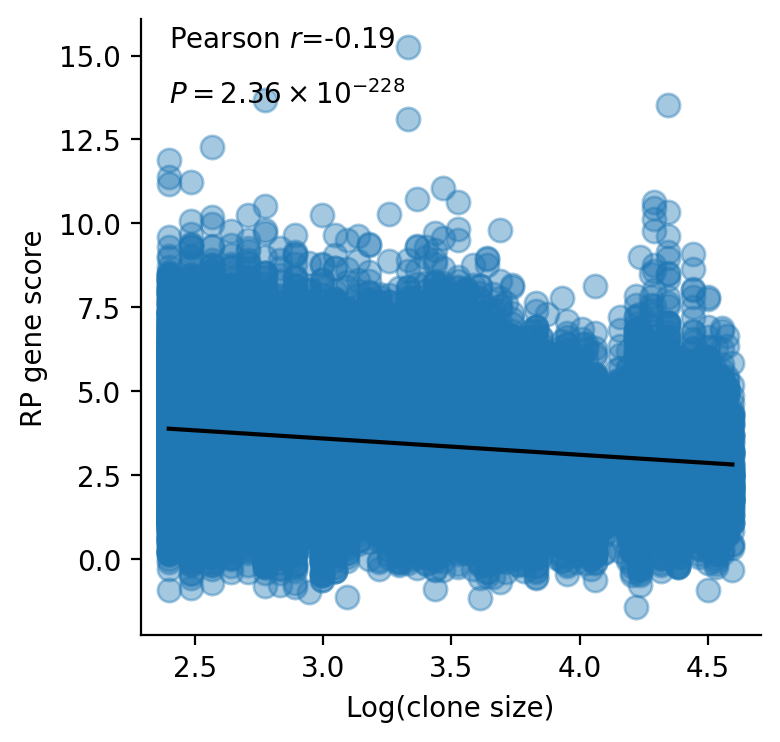

In [229]:
fig, ax = plt.subplots(figsize=(4,4))
pv.corr_plot(np.log(depths), adata.obs['score'], ax)
ax.set_xlabel('Log(clone size)')
ax.set_ylabel('RP gene score')
plt.show()

In [243]:
from sklearn.preprocessing import scale
import seaborn as sns
from scipy.stats import spearmanr
gene_vel_map = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns)


genes1 = gene_vel_map.index[(gene_vel_map>0).to_numpy().flatten()]
genes2 = gene_vel_map.index[(gene_vel_map<0).to_numpy().flatten()]
genes1 = genes1[np.argsort(scale(sd.x_normed[genes1], axis=0).sum(0))]
genes2 = genes2[np.argsort(scale(sd.x_normed[genes2], axis=0).sum(0))]
genes1 = genes1[::-1]

genetraj1 = []
for i in genes1:
    genetraj1.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj1 = np.array(genetraj1)
# genetraj1 = np.log(1+genetraj1)
# genetraj1 = (genetraj1.T / np.max(genetraj1, axis=1)).T

genetraj2 = []
for i in genes2:
    genetraj2.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj2 = np.array(genetraj2)
# genetraj2 = np.log(1+genetraj2)
# genetraj2 = (genetraj2.T / np.max(genetraj2, axis=1)).T

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be 

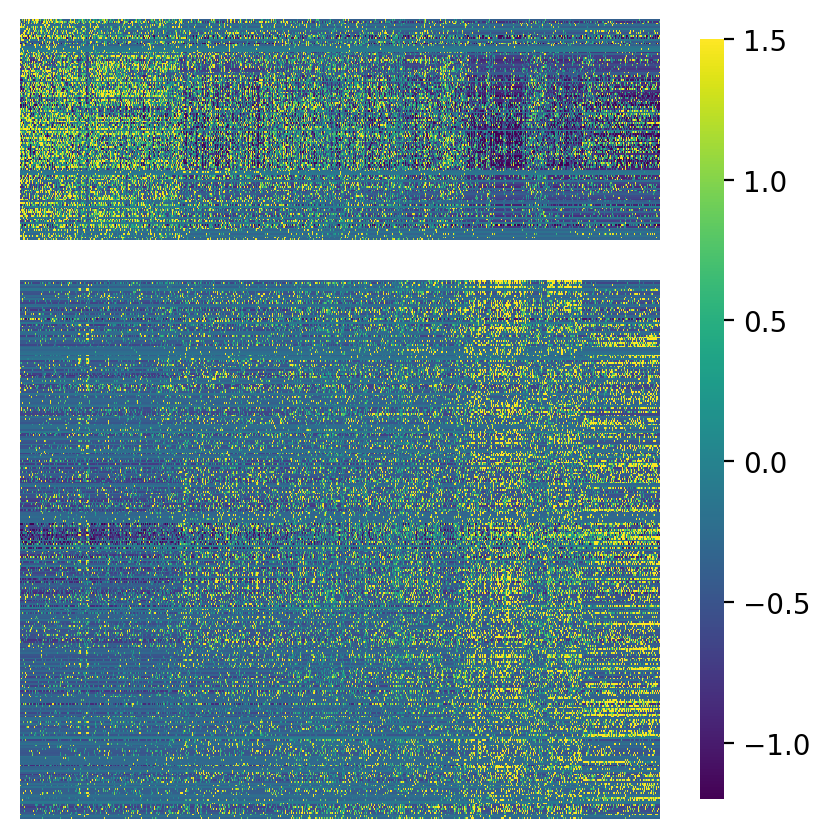

In [246]:
fig = plt.figure(figsize=(4,4))
h1 = len(genes1)/(len(genes1)+len(genes2))
h2 = len(genes2)/(len(genes1)+len(genes2))
ax1 = plt.axes([0.05, 0, 0.8, 0.95*h1])
ax2 = plt.axes([0.05, 0.95*h1+0.05, 0.8, 0.95*h2])
ax3 = plt.axes([0.9,0.025,0.03,0.95])

ax1 = sns.heatmap(genetraj1, cmap='viridis', ax=ax1, cbar_ax=ax3,vmax=1.5, vmin=-1.2, xticklabels=False, yticklabels='')
ax2 = sns.heatmap(genetraj2[::-1], cmap='viridis', ax=ax2, cbar=False,vmax=1.5, vmin=-1.2, xticklabels=False, yticklabels='')

plt.show()

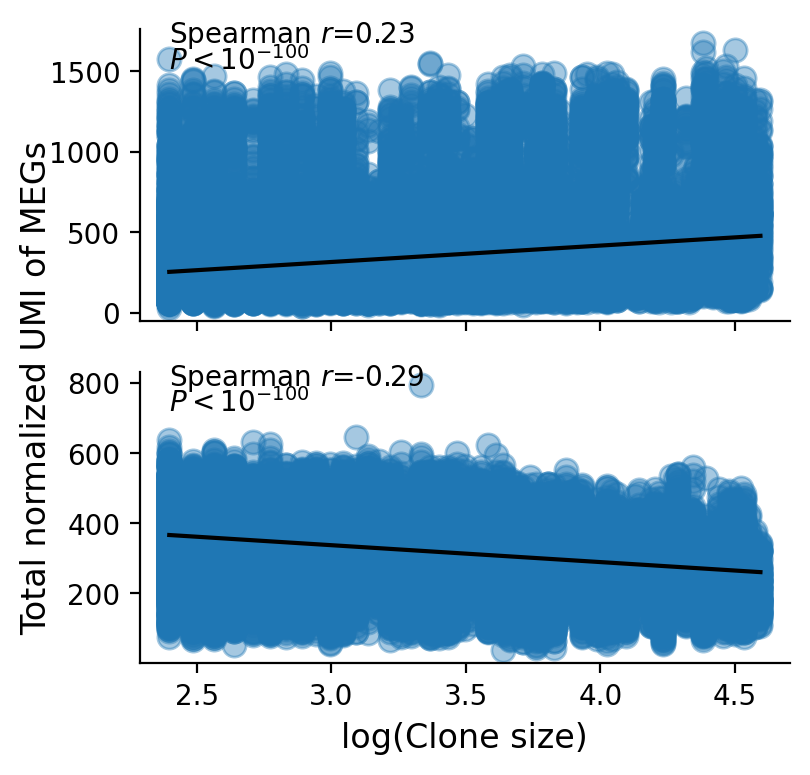

In [288]:

from scipy.stats import spearmanr
# genes1 = vels.index[vels['velocity']>0].to_numpy()
# genes2 = vels.index[vels['velocity']<0].to_numpy()


x = np.log(depths)
y = sd.x_normed[genes1].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b

fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
pv.corr_plot(x,y, ax[0], stats='spearman')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)



y = sd.x_normed[genes2].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b


pv.corr_plot(x,y, ax[1], stats='spearman')

fig.text(0, 0.5, 'Total normalized UMI of MEGs', va='center', rotation='vertical',fontsize=12)
ax[1].set_xlabel('log(Clone size)', fontsize=12)
plt.tight_layout()
plt.show()